# SETUP

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

import tensorflow as tf
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    median_absolute_error, 
    explained_variance_score
)

import datetime

from geexhp import loadingdata as ld

from geexhp import datavis as dvis
dvis.configure_matplotlib()

# DATA LOADING PIPELINE IMPLEMENTATION

In [3]:
train_ds = ld.read_tfrecord("../data/train.tfrecord", shuffle_buffer=400000, repeat=True)
val_ds   = ld.read_tfrecord("../data/val.tfrecord", shuffle_buffer=50000, repeat=True)
test_ds  = ld.read_tfrecord("../data/test.tfrecord")

In [4]:
TRAIN_SAMPLES = 892073
VAL_SAMPLES = 107422
BATCH_SIZE = 256

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

# Model

## Build

In [5]:
def residual_block_1D(x,
                      num_filters=32,
                      kernel_size=3,
                      activation='swish',
                      padding='same',
                      strides = 1
                      ):
    
    shortcut = x

    # First Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation)(y)

    # Second Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(y)
    y = tf.keras.layers.BatchNormalization()(y)

    # Skip connection
    y = tf.keras.layers.Add()([shortcut, y])
    y = tf.keras.layers.Activation(activation)(y)
    
    y = tf.keras.layers.MaxPooling1D(pool_size=1)(y)

    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, strides=strides, activation=None)(y)
    
    return y

In [6]:
def small_transformer_block(x,
                            num_heads=4,
                            key_dim=32
                            ):
    
    # Self-Attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)

    # Feed-forward
    ff = tf.keras.layers.Dense(64, activation='swish')(x)
    ff = tf.keras.layers.Dense(x.shape[-1])(ff)  # project back to input feature dim
    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization()(x)
    
    return x

In [7]:
def build_model():
    """
    Creates a model with:
    - UV, VIS, NIR branches (each with conv+res+transformer)
    - Merged dense layers
    - Two sub-heads for (Physical parameters) and (Chemical log abundances)
    """

    # ----------------------
    #  LISTS / CONSTANTS
    # ----------------------
    physical_targets = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE"
    ]
    main_chemical_targets = ['O2', 'O3']
    other_chemical_targets = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']
    
    # -----------
    # INPUTS
    # -----------
    input_uv  = tf.keras.layers.Input(shape=(8, 1),  name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    spectrum_lenghth = 151

    spectrum = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])

    spectrum = residual_block_1D(spectrum, num_filters=20, kernel_size=int(spectrum_lenghth/4), strides=2)
    spectrum = residual_block_1D(spectrum, num_filters=20, kernel_size=int(spectrum_lenghth/2*4), strides=2)
    spectrum = small_transformer_block(spectrum, num_heads=2, key_dim=8)  # smaller since only 8 channels in UV
    spectrum = tf.keras.layers.GlobalAveragePooling1D()(spectrum)  # or Flatten

    shortcut = spectrum
    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(spectrum)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Add()([shortcut, shortcut])

    # ------------------------
    #   SUB-HEADS
    # ------------------------
    # Physical parameters (4 outputs)
    phys = tf.keras.layers.Dense(16, kernel_initializer="he_normal")(x)
    phys_out = tf.keras.layers.Dense(
        len(physical_targets),
        activation='linear',
        name='physical_output'
    )(phys)

    # Chemical abundances (2 outputs)
    main_chem = tf.keras.layers.Dense(16, kernel_initializer="he_normal")(x)
    main_chem_out = tf.keras.layers.Dense(
        len(main_chemical_targets),
        activation='linear',
        name='main_chemical_output'
    )(main_chem)

    # Chemical abundances (6 outputs)
    other_chem = tf.keras.layers.Dense(16, kernel_initializer="he_normal")(x)
    other_chem_out = tf.keras.layers.Dense(
        len(other_chemical_targets),
        activation='linear',
        name='other_chemical_output'
    )(other_chem)

    # -----------
    # MODEL
    # -----------
    outputs = {
        'physical_output': phys_out,
        'main_chemical_output': main_chem_out,
        'other_chemical_output': other_chem_out
    }
    model = tf.keras.Model(
        inputs=[input_uv, input_vis, input_nir],
        outputs=outputs,
        name="Net22"
    )
    # ---------------------------
    #    LOSSES & COMPILATION
    # ---------------------------
    # We'll use 'mae' for both heads. 
    # By default, Keras will average the MAE across each sub-head's dimension.
    losses = {
        'physical_output': 'mae',
        'main_chemical_output': 'mae',
        'other_chemical_output': 'mae'
    }

    loss_weights = {
        'physical_output': 1.0,
        'main_chemical_output': 2.0,
        'other_chemical_output': 1.5
    }

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=opt,
        loss=losses,
        loss_weights=loss_weights
    )

    return model

## Train

In [8]:
model = build_model()

if False:
    tf.keras.utils.plot_model(
    model,
    #to_file="network.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
    )

In [9]:
EPOCHS = 5

log_dir = "logs/fit22/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Final training call
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 1175s 336ms/step - loss: 0.6235 - main_chemical_output_loss: 0.2250 - other_chemical_output_loss: 0.2055 - physical_output_loss: 0.1930 - val_loss: 0.3923 - val_main_chemical_output_loss: 0.1308 - val_other_chemical_output_loss: 0.1209 - val_physical_output_loss: 0.1406
Epoch 2/5
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 1178s 338ms/step - loss: 0.3710 - main_chemical_output_loss: 0.1254 - other_chemical_output_loss: 0.1101 - physical_output_loss: 0.1355 - val_loss: 0.3432 - val_main_chemical_output_loss: 0.1109 - val_other_chemical_output_loss: 0.1066 - val_physical_output_loss: 0.1257
Epoch 3/5
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 1145s 329ms/step - loss: 0.3378 - main_chemical_output_loss: 0.1109 - other_chemical_output_loss: 0.1013 - physical_output_loss: 0.1256 - val_loss: 0.3168 - val_main_chemical_output_loss: 0.0937 - val_other_chemical_output_loss: 0.1021 - val_physical_output_loss: 0.1210
Epoch 4/5
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 1156s 332ms/step - loss

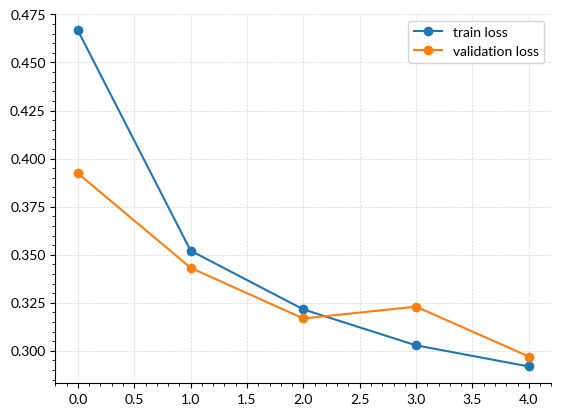

In [10]:
plt.plot(range(EPOCHS), history.history["loss"], marker="o", label="train loss")
plt.plot(range(EPOCHS), history.history["val_loss"], marker="o", label="validation loss")
plt.legend();

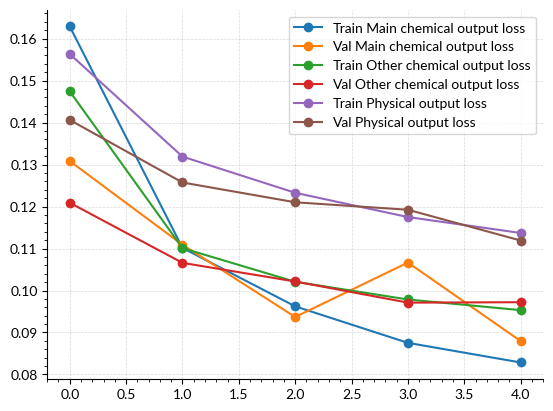

In [11]:
plt.plot(range(EPOCHS), history.history["main_chemical_output_loss"], marker="o", label="Train Main chemical output loss")
plt.plot(range(EPOCHS), history.history["val_main_chemical_output_loss"], marker="o", label="Val Main chemical output loss")

plt.plot(range(EPOCHS), history.history["other_chemical_output_loss"], marker="o", label="Train Other chemical output loss")
plt.plot(range(EPOCHS), history.history["val_other_chemical_output_loss"], marker="o", label="Val Other chemical output loss")

plt.plot(range(EPOCHS), history.history["physical_output_loss"], marker="o", label="Train Physical output loss")
plt.plot(range(EPOCHS), history.history["val_physical_output_loss"], marker="o", label="Val Physical output loss")

plt.legend();

In [12]:
model.save('NN_22.keras')

# Testing

In [13]:
# model = tf.keras.models.load_model("NN_test_12-3.keras")

In [15]:
y_true_phys_all = []
y_true_main_chem_all = []
y_true_other_chem_all = []

y_pred_phys_all = []
y_pred_main_chem_all = []
y_pred_other_chem_all = []

for x_batch, y_batch in test_ds:
    # 1) Get model predictions for this batch
    predictions = model(x_batch, training=False)
    pred_phys_batch = predictions['physical_output']
    pred_main_chem_batch = predictions['main_chemical_output']
    pred_other_chem_batch = predictions['other_chemical_output']

    # 2) Collect ground-truth values
    true_phys_batch = y_batch['physical_output']
    true_main_chem_batch = y_batch['main_chemical_output']
    true_other_chem_batch = y_batch['other_chemical_output']

    # 3) Append to our running lists
    y_true_phys_all.append(true_phys_batch.numpy())
    y_true_main_chem_all.append(true_main_chem_batch.numpy())
    y_true_other_chem_all.append(true_other_chem_batch.numpy())

    y_pred_phys_all.append(pred_phys_batch.numpy())
    y_pred_main_chem_all.append(pred_main_chem_batch.numpy())
    y_pred_other_chem_all.append(pred_other_chem_batch.numpy())

# 4) Concatenate the list of batches into a single array for each head
y_true_phys_all = np.concatenate(y_true_phys_all, axis=0)   
y_true_main_chem_all = np.concatenate(y_true_main_chem_all, axis=0)   
y_true_other_chem_all = np.concatenate(y_true_other_chem_all, axis=0)   

y_pred_phys_all = np.concatenate(y_pred_phys_all, axis=0)   
y_pred_main_chem_all = np.concatenate(y_pred_main_chem_all, axis=0)   
y_pred_other_chem_all = np.concatenate(y_pred_other_chem_all, axis=0)   


2025-03-08 09:43:49.285029: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


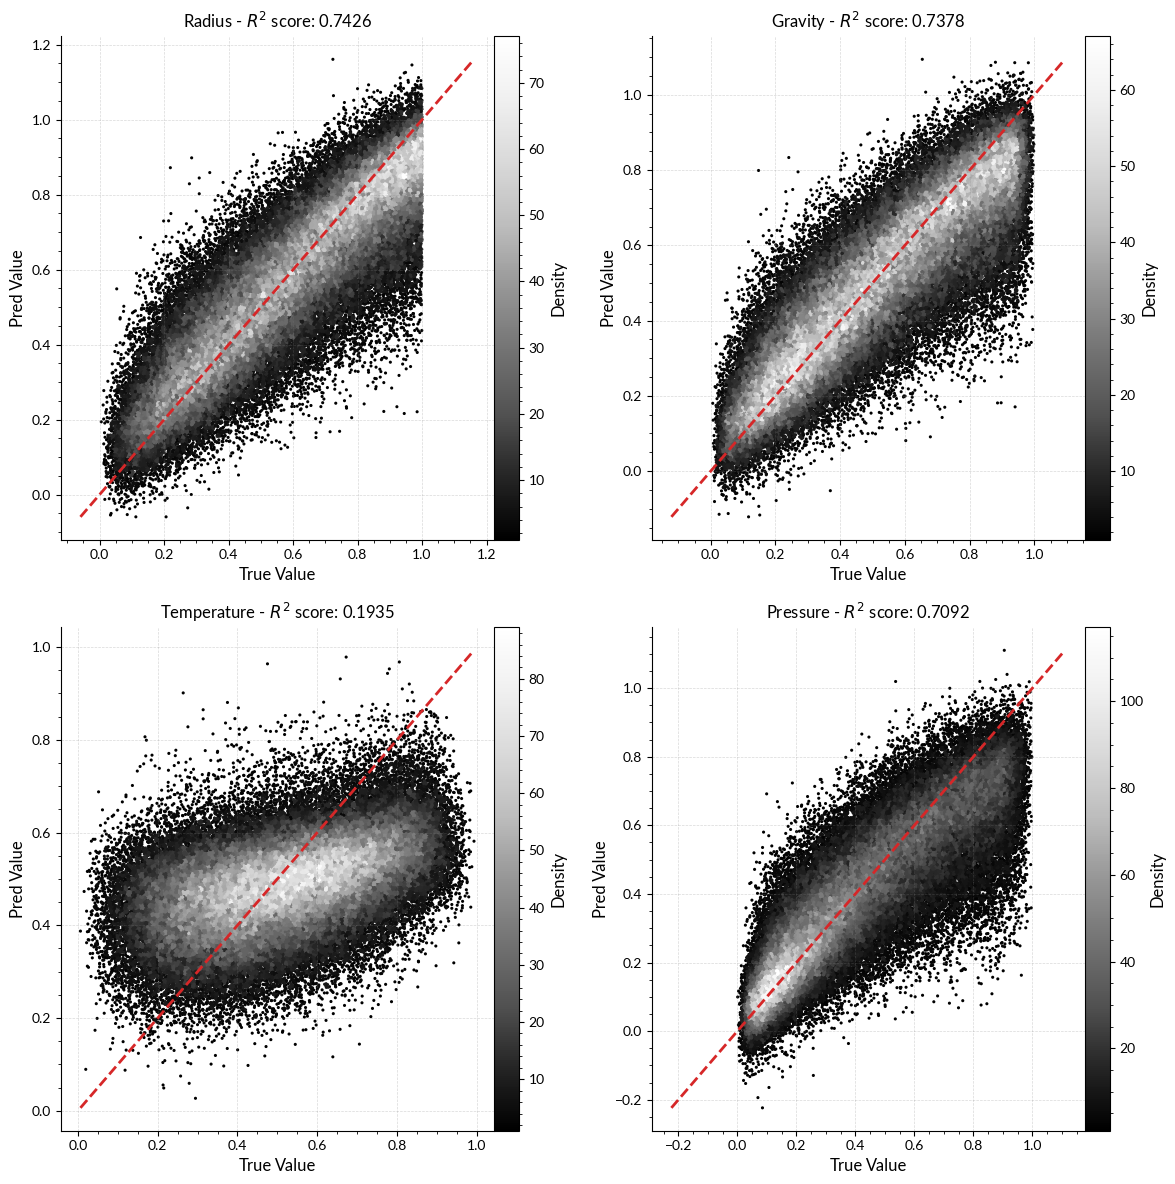

In [36]:
physical_parameters = ['Radius', 'Gravity', 'Temperature', 'Pressure']
n_keys = len(physical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols)) 

plt.figure(figsize=(12, 12))

metrics_list = []

for i, phys_param in enumerate(physical_parameters):
    phys_true = np.array([y_true_phys_all[row][i] for row in range(len(y_true_phys_all))])
    phys_pred = np.array([y_pred_phys_all[row][i] for row in range(len(y_pred_phys_all))])
    
    min_val = min(phys_true.min(), phys_pred.min())
    max_val = max(phys_true.max(), phys_pred.max())
    
    r2 = r2_score(phys_true, phys_pred)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    
    # Compute density using a 2D histogram
    nbins = 100
    hist, xedges, yedges = np.histogram2d(phys_true, phys_pred, bins=nbins)
    # For each point, determine which bin it falls into
    xidx = np.clip(np.searchsorted(xedges, phys_true) - 1, 0, nbins-1)
    yidx = np.clip(np.searchsorted(yedges, phys_pred) - 1, 0, nbins-1)
    # Map each point to its density value (the count in its bin)
    z = hist[xidx, yidx]

    sc = ax.scatter(phys_true, phys_pred, c=z, s=5, cmap='Greys_r', edgecolor='none')
    cb = plt.colorbar(sc, ax=ax, pad=0)
    cb.set_label("Density")

    ax.set_title(fr'{physical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(phys_true, phys_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(phys_true, phys_pred)
    med_ae = median_absolute_error(phys_true, phys_pred)
    exp_var = explained_variance_score(phys_true, phys_pred)
    
    metrics_list.append({
        "Output": phys_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
plt.tight_layout();

In [18]:
df_metrics

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,Radius,0.742574,0.744839,0.016648,0.129029,0.098812,0.078027
1,Gravity,0.737768,0.741679,0.016998,0.130376,0.099400,0.077865
2,Temperature,0.193486,0.210050,0.031728,0.178124,0.145718,0.129350
3,Pressure,0.709213,0.720005,0.019575,0.139912,0.104082,0.078093


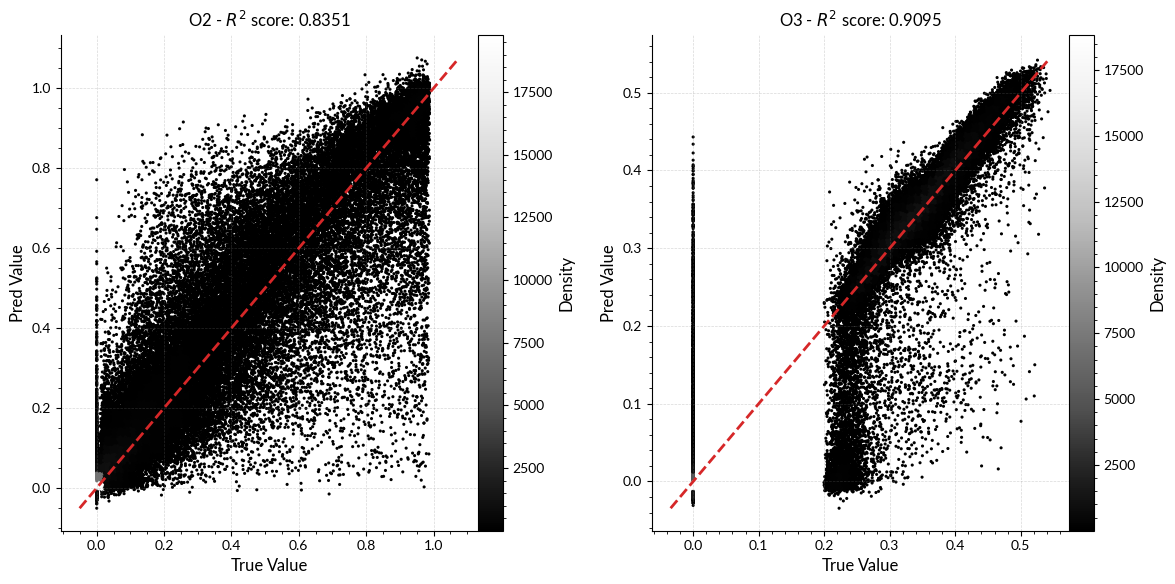

In [46]:
main_chemical_parameters = ['O2', 'O3']

n_keys = len(main_chemical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols)) 

plt.figure(figsize=(12, 6))

metrics_list = []

for i, chem_param in enumerate(main_chemical_parameters):
    chem_true = np.array([y_true_main_chem_all[row][i] for row in range(len(y_true_main_chem_all))])
    chem_pred = np.array([y_pred_main_chem_all[row][i] for row in range(len(y_pred_main_chem_all))])
    
    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())
    
    r2 = r2_score(chem_true, chem_pred)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    
    # Compute density using a 2D histogram
    nbins = 50
    hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    z = hist[xidx, yidx]
    
    # Scatter plot using density as color, with Greys_r cmap
    sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    
    # Add colorbar with label "Density"
    cb = plt.colorbar(sc, ax=ax, pad=0)
    cb.set_label("Density")
    
    ax.set_title(fr'{main_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")
    
    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)
    
    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics_chem = pd.DataFrame(metrics_list)
plt.tight_layout()
plt.show()

In [20]:
df_metrics_chem

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,O2,0.835108,0.837255,0.014595,0.120811,0.070647,0.030959
1,O3,0.909522,0.910040,0.002553,0.050525,0.022345,0.008881


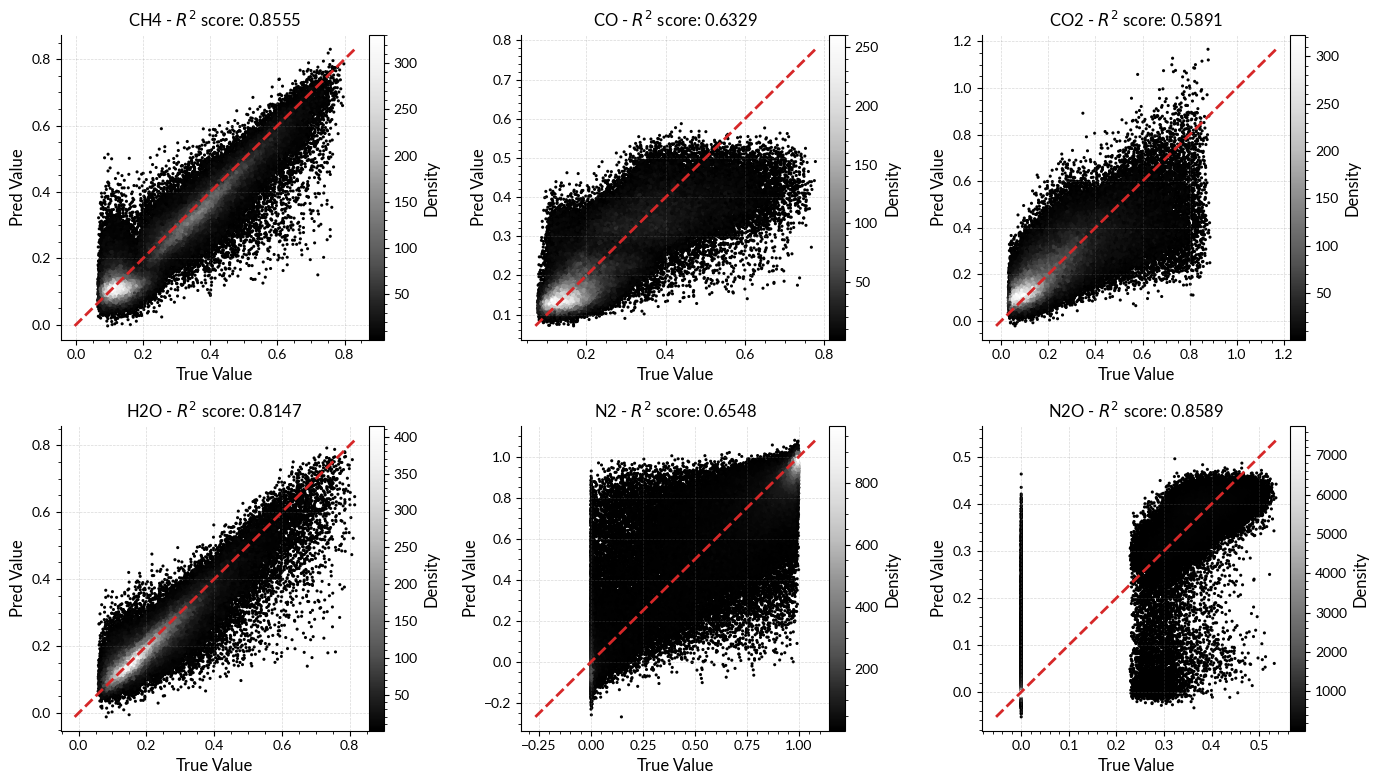

In [52]:
other_chemical_parameters = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

n_keys = len(other_chemical_parameters)
n_cols = 3
n_rows = 2 
plt.figure(figsize=(14, 8))

metrics_list = []

for i, chem_param in enumerate(other_chemical_parameters):
    chem_true = np.array([y_true_other_chem_all[row][i] for row in range(len(y_true_other_chem_all))])
    chem_pred = np.array([y_pred_other_chem_all[row][i] for row in range(len(y_pred_other_chem_all))])

    # Correct min and max values using both true and pred arrays
    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())
    
    r2 = r2_score(chem_true, chem_pred)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    
    # Compute density with a 2D histogram
    nbins = 100
    hist, xedges, yedges = np.histogram2d(chem_true, chem_pred, bins=nbins)
    xidx = np.clip(np.searchsorted(xedges, chem_true) - 1, 0, nbins-1)
    yidx = np.clip(np.searchsorted(yedges, chem_pred) - 1, 0, nbins-1)
    z = hist[xidx, yidx]
    
    # Create the scatter plot using density for the color (Greys_r)
    sc = ax.scatter(chem_true, chem_pred, s=5, c=z, cmap='Greys_r', edgecolor="none", linewidth=0.3)
    
    # Add a colorbar with label "Density"
    cb = plt.colorbar(sc, ax=ax, pad=0)
    cb.set_label("Density")
    
    ax.set_title(fr'{other_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")
    
    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)
    
    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

plt.tight_layout()

df_metrics_chem = pd.DataFrame(metrics_list)
plt.show()

In [53]:
df_metrics_chem

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,CH4,0.855474,0.874796,0.003883,0.062316,0.045433,0.034695
1,CO,0.632862,0.644138,0.006576,0.081093,0.058181,0.041297
2,CO2,0.589069,0.589707,0.012780,0.113047,0.079814,0.055493
3,H2O,0.814655,0.823068,0.002713,0.052084,0.035307,0.024006
4,N2,0.654837,0.655901,0.036796,0.191822,0.130423,0.081813
5,N2O,0.858922,0.860227,0.004312,0.065665,0.037490,0.020558
